/tmp/ipykernel_1570547/1134290582.py:188: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(tab.index, rotation=45, fontdict={'fontsize':28})


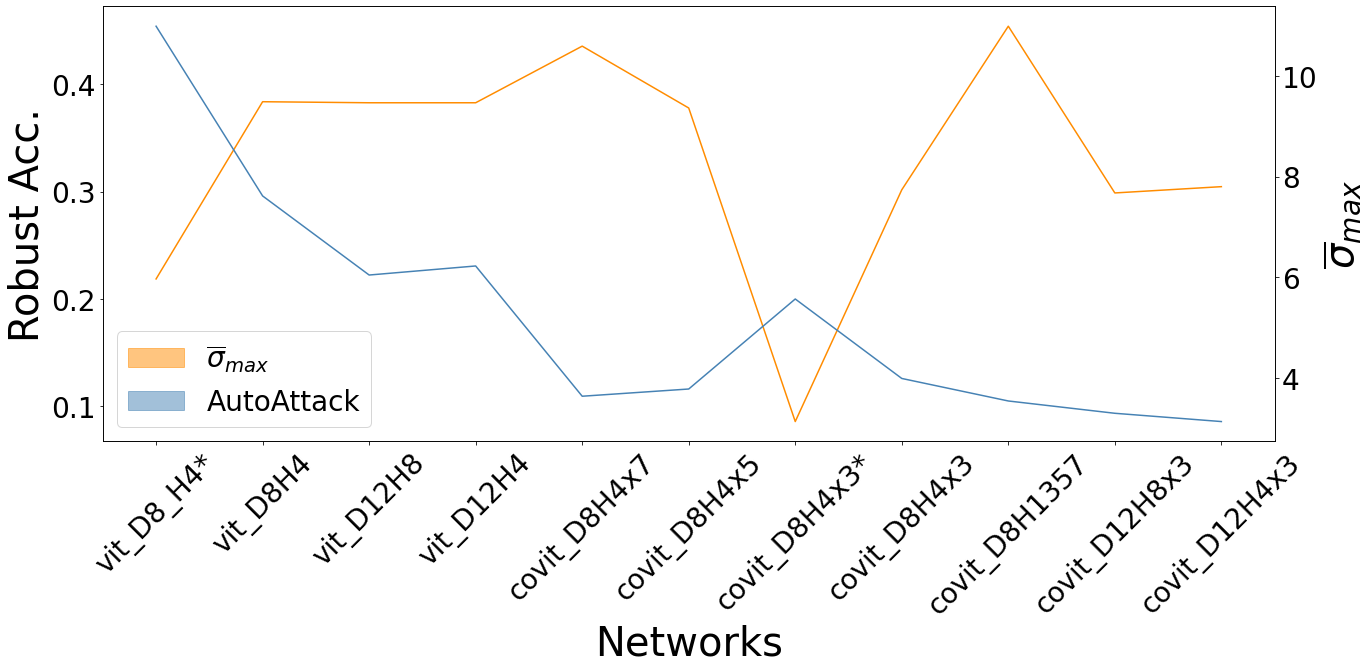

In [53]:
import os 
import math
import torch 
import pandas as pd 
from util import Logger

import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from mpl_toolkits.axes_grid1 import host_subplot
import seaborn as sns


vit_cifar10_names = ['vit_D8_E512_H4_P16(200)_on_cifar10', 'vit_D8_E512_H4_P32(200)_on_cifar10', \
                     'vit_D12_E512_H4_P32(200)_on_cifar10', 'vit_D12_E512_H8_P32(200)_on_cifar10'] 
covit_cifar10_names =['covit_D8_E512_H3333_P16(200)_on_cifar10', 'covit_D8_E512_H1357_P32(200)_on_cifar10',\
                      'covit_D8_E512_H3333_P32(200)_on_cifar10', 'covit_D8_E512_H5555_P32(200)_on_cifar10', \
                      'covit_D8_E512_H7777_P32(200)_on_cifar10', 'covit_D12_E512_H3333_P32(200)_on_cifar10', \
                      'covit_D12_E512_H33333333_P32(200)_on_cifar10'] 
resnet_imagenet_names = ['resnet18', 'resnet34', 'resnet50', 'resnet34d', 'resnet50d', 'resnet101d', 'resnet152d',\
                         'wide_resnet50_2', 'wide_resnet101_2']

resnext_imagenet_names = ['resnext50_32x4d', 'resnext50d_32x4d', 'resnext101_32x8d']
mobilenet_imagenet_names = ['mobilenetv2_100']
vit_imagenet_names = ['vit_small_patch16_224', 'vit_base_patch16_224', 'vit_large_patch16_224']
mixer_imagenet_names = ['mixer_b16_224', 'mixer_l16_224']

net_on_imagenet = resnet_imagenet_names + resnext_imagenet_names + mobilenet_imagenet_names + vit_imagenet_names + mixer_imagenet_names
net_on_cifar10 = vit_cifar10_names + covit_cifar10_names

def table_converter(att_result_df, topk = 1, dataset = 'imagenet' ,\
                    att_names = ['aa_L2_eps(1.00)', 'fgsm_Linf_eps(0.01)', \
                               'pgd_L2_eps(1.00)_alpha(0.01)_steps(50)', 'pgd_L2_eps(1.00)_alpha(0.01)_steps(7)', \
                               'cw_L2_c(1.0)_kappa(0.0)_lr(0.01)_steps(50)']):
    table = pd.DataFrame([])
    for att_name in att_names:
        cols = ['networks', f'rob_acc_top{topk}']
        sub_att_df = att_result_df.loc[(att_result_df.loc[:,'attacks'] == att_name)&\
                                       (att_result_df.loc[:,'dataset'] == dataset), cols]
        sub_table_top_1 = sub_att_df.rename(columns={f'rob_acc_top{topk}': att_name}).set_index('networks')
        table = pd.concat([table, sub_table_top_1], axis=1)
    return table 

def table_adder(tab, dataset='imagenet'):
    logger = Logger()    
    for net_name in tab.index:
        # set up the number of iterations for corresponding datasets  
        if dataset == 'cifar10':
            iters = 20
        elif dataset == 'imagenet':
            iters = 100

        # read the csv file from from the corresponding net name, attacking name and dataset name  
        msv_file = f'msv_iters({iters})_for_{net_name}_on_{dataset}'
        logger._load_from_log(f'results/{msv_file}.csv', index_col=0)
        msv_df = logger.logging_files[msv_file]

        # take out the columns that is usefull 
        indications = ['InputResize(0)_0', 'label', 'prediction', 'pred_adv']
        cols = [col_name for col_name in msv_df.columns if col_name not in indications]    
        tab.loc[net_name, 'num_of_layers'] = len(cols)
        
        cols_body = [col_name for col_name in cols if col_name.split('(')[0] in \
                    ['BasicBlock', 'Bottleneck', 'Block', 'MixerBlock', 'Bottleneck', 'InvertedResidual',\
                     'EncoderBlock', 'EncoderBlock_Conv1D']]
        tab.loc[net_name, 'num_of_body_layers'] = len(cols_body)

        # calculate the sum of log maximum singular value 
        tab.loc[net_name, 'mean_msv_all'] = msv_df.loc[:, cols].mean(axis=1).mean()
        tab.loc[net_name, 'std_msv_all'] = msv_df.loc[:, cols].mean(axis=1).std()

        tab.loc[net_name, 'mean_msv_body'] = msv_df.loc[:, cols_body].mean(axis=1).mean()
        tab.loc[net_name, 'std_msv_body'] = msv_df.loc[:, cols_body].mean(axis=1).std()

def scalar_plot(tab, dataset='imagenet'):
    if dataset == 'imagenet':
        net_color_map = { 
                        'resnet18':'royalblue', 
                        'resnet34':'royalblue',
                        'resnet50':'royalblue',
                        'resnet34d':'slategrey',
                        'resnet50d':'slategrey',
                        'resnet101d':'slategrey',
                        'resnet152d':'slategrey',
                        'wide_resnet50_2':'lightgreen',
                        'wide_resnet101_2':'lightgreen',
                        'resnext50_32x4d':'orange',
                        'resnext50d_32x4d':'orange',
                        'resnext101_32x8d':'orange',
                        'mobilenetv2_100':'gold',
                        'vit_small_patch16_224':'red',
                        'vit_base_patch16_224':'red',
                        'vit_large_patch16_224':'red',
                        'mixer_b16_224':'tomato',
                        'mixer_l16_224':'tomato'
                        }
        # elif dataset == 'cifar10':
            # net_color_map = { 
            #             'vit_D8_E512_H4_P16(200)':'darkblue', 
            #             'vit_D8_E512_H4_P32(200)':'navy',
            #             'vit_D12_E512_H4_P32(200)':'royalblue',
            #             'vit_D12_E512_H8_P32(200)':'slategrey',
            #             'covit_D8_E512_H3333_P16(200)':'lightsteelblue',
            #             'covit_D8_E512_H1357_P32(200)':'darkcyan',
            #             'covit_D8_E512_H3333_P32(200)':'darkturquoise',
            #             'covit_D8_E512_H5555_P32(200)':'orange',
            #             'covit_D8_E512_H7777_P32(200)':'burlywood',
            #             'covit_D12_E512_H3333_P32(200)':'goldenrod',
            #             'covit_D12_E512_H33333333_P32(200)':'dimgray',
            #             }
        fig, axs = plt.subplots(figsize=(14, 8))

        for net_name in net_color_map.keys():
            scalar = ((tab.loc[net_name, 'num_of_layers']*0.1)**2)*30 
            axs.scatter(tab.loc[net_name,'aa_L2_eps(1.00)'],\
                        tab.loc[net_name,'mean_msv_body'],\
                        marker='o', s=scalar, alpha=0.6,\
                        c=net_color_map[net_name]
                        )
        axs.set_xlabel('Robust Accuracy (Top1)', fontsize=18)
        axs.set_ylabel(r'$\overline{\sigma}_{max}$', fontsize=18)
        axs.tick_params(axis='x', labelsize=12)
        axs.tick_params(axis='y', labelsize=12)

        marker_resnet = mpatches.Patch(color='royalblue', label='ResNets', alpha=0.5)
        marker_resnetd = mpatches.Patch(color='slategrey', label='ResNetd', alpha=0.5)
        marker_wideresnet = mpatches.Patch(color='lightgreen', label='WideResNets', alpha=0.5)
        marker_resnext = mpatches.Patch(color='orange', label='ResNeXts', alpha=0.5)
        marker_mobilenet = mpatches.Patch(color='gold', label='MobileNet', alpha=0.5)
        marker_vit = mpatches.Patch(color='red', label='ViT', alpha=0.5)
        marker_mixer = mpatches.Patch(color='tomato', label='MLP-Mixer', alpha=0.5)

        axs.legend(
                   handles=[marker_resnet, marker_resnetd, marker_wideresnet, marker_resnext, marker_mobilenet, marker_vit, marker_mixer], \
                   fontsize=18
                   )

    elif dataset == 'cifar10':
        index_new = []
        for n in tab.index:
            if n == 'vit_D8_E512_H4_P16(200)':
                index_new.append('vit_D8_H4*')                 

            elif n == 'vit_D8_E512_H4_P32(200)':
                index_new.append('vit_D8H4')                  

            elif n == 'covit_D8_E512_H3333_P16(200)':
                index_new.append('covit_D8H4x3*')                 

            elif n == 'covit_D8_E512_H1357_P32(200)':
                index_new.append('covit_D8H1357')                 

            elif n == 'covit_D8_E512_H3333_P32(200)':
                index_new.append('covit_D8H4x3')                 

            elif n == 'covit_D8_E512_H5555_P32(200)':
                index_new.append('covit_D8H4x5')                 

            elif n == 'covit_D8_E512_H7777_P32(200)':
                index_new.append('covit_D8H4x7')                 

            elif n == 'vit_D12_E512_H4_P32(200)':
                index_new.append('vit_D12H4')                 

            elif n == 'vit_D12_E512_H8_P32(200)':
                index_new.append('vit_D12H8')                 

            elif n == 'covit_D12_E512_H3333_P32(200)':
                index_new.append('covit_D12H4x3')                 

            elif n == 'covit_D12_E512_H33333333_P32(200)':
                index_new.append('covit_D12H8x3')                 

        tab.index = index_new
        tab = tab.sort_index(ascending=False)

        fig, axs = plt.subplots(figsize=(21, 8))
        axs2 = axs.twinx()
        
        axs.plot(tab.loc[:, 'aa_L2_eps(1.00)'], color='darkorange')
        # axs2.plot(tab.loc[:, 'fgsm_Linf_eps(0.01)'], color='bisque', label='fgsm')
        # axs2.plot(tab.loc[:, 'pgd_L2_eps(1.00)_alpha(0.01)_steps(7)'], color='orange', label='pdgL2(7)')
        # axs2.plot(tab.loc[:, 'pgd_L2_eps(1.00)_alpha(0.01)_steps(50)'], color='burlywood', label='pdgL2(50)')
        axs2.plot(tab.loc[:, 'mean_msv_body'], color='steelblue')

        # set x-axis: titles, fonts 
        axs.set_xlabel('Networks', fontsize=40)
        axs.set_xticklabels(tab.index, rotation=45, fontdict={'fontsize':28})

        # set y-axis
        axs.set_ylabel(r'Robust Acc.', fontsize=40)
        axs.tick_params(axis='y', labelsize=28)

        axs2.set_ylabel(r'$\overline{\sigma}_{max}$', fontsize=40)
        axs2.tick_params(axis='y', labelsize=28)

        # set up marker for the legend
        marker_msv = mpatches.Patch(color='darkorange', label=r'$\overline{\sigma}_{max}$', alpha=0.5)
        marker_rob_acc = mpatches.Patch(color='steelblue', label=r'AutoAttack', alpha=0.5)
        axs.legend(
                   handles=[marker_msv, marker_rob_acc], \
                   fontsize=28)

dataset = 'cifar10'
logger = Logger()
logger._load_from_log('results/attacking_results.csv')
tab = table_converter(logger.logging_files['attacking_results'], dataset=dataset)
table_adder(tab, dataset)
scalar_plot(tab, dataset)


In [61]:
tab.loc[:,\
    # ['mean_msv_body', 'std_msv_body', 'pgd_L2_eps(1.00)_alpha(0.01)_steps(50)', 'cw_L2_c(1.0)_kappa(0.0)_lr(0.01)_steps(50)']\
    # ['aa_L2_eps(1.00)']
    # ['mean_msv_body', 'std_msv_body']
        ]

,aa_L2_eps(1.00),fgsm_Linf_eps(0.01),pgd_L2_eps(1.00)_alpha(0.01)_steps(50),pgd_L2_eps(1.00)_alpha(0.01)_steps(7),cw_L2_c(1.0)_kappa(0.0)_lr(0.01)_steps(50),num_of_layers,num_of_body_layers,mean_msv_all,std_msv_all,mean_msv_body,std_msv_body
vit_D8_H4*,0.218750,0.153320,0.538086,0.798828,0.000000,10.0,8.0,9.659463,1.096678,10.987909,1.371151
vit_D8H4,0.383789,0.201172,0.629883,0.806641,0.004883,10.0,8.0,6.950830,0.745030,7.618627,0.931982
covit_D8H4x3*,0.085938,0.110352,0.411133,0.836914,0.000000,10.0,8.0,5.666739,0.233881,5.572783,0.292007
covit_D8H1357,0.454102,0.225586,0.712891,0.858398,0.006836,10.0,8.0,3.719680,0.175693,3.548272,0.219372
covit_D8H4x3,0.301758,0.157227,0.631836,0.845703,0.000000,10.0,8.0,4.223322,0.215172,3.995268,0.268332
covit_D8H4x5,0.377930,0.175781,0.643555,0.856445,0.002930,10.0,8.0,4.003938,0.173607,3.785860,0.216669
covit_D8H4x7,0.435547,0.211914,0.687500,0.843750,0.015625,10.0,8.0,3.767192,0.167083,3.642500,0.208793
vit_D12H4,0.382812,0.215820,0.615234,0.784180,0.004883,14.0,12.0,5.940986,0.532058,6.228321,0.621056
vit_D12H8,0.382812,0.232422,0.633789,0.801758,0.006836,14.0,12.0,5.818364,0.499254,6.048636,0.582865
covit_D12H4x3,0.304688,0.162109,0.625000,0.848633,0.000977,14.0,12.0,3.413302,0.166631,3.139679,0.194000


In [3]:
tab.to_csv('./log/results/just_look.csv')

In [323]:
tab.loc[:,['mean_msv_all', 'std_msv_all', 'fgsm_Linf_eps(0.01)',\
           'pgd_L2_eps(1.00)_alpha(0.01)_steps(7)', 'pgd_L2_eps(1.00)_alpha(0.01)_steps(50)',\
            'aa_L2_eps(1.00)']].to_csv('./log/results/output_for_vit_covit.csv')

      InputResize(0)_0  Conv2d(0)_1  BatchNorm2d(1)_2  ReLU6(2)_3  \
0             4.452133      9.48836        441.899811         1.0   
1             4.452133      9.48836        441.899811         1.0   
2             4.452133      9.48836        441.899811         1.0   
3             4.452133      9.48836        441.899811         1.0   
4             4.452133      9.48836        441.899811         1.0   
...                ...          ...               ...         ...   
1019          4.452133      9.48836        441.899811         1.0   
1020          4.452133      9.48836        441.899811         1.0   
1021          4.452133      9.48836        441.899811         1.0   
1022          4.452133      9.48836        441.899811         1.0   
1023          4.452133      9.48836        441.899811         1.0   

      DepthwiseSeparableConv(0)_4  InvertedResidual(0)_5  \
0                       59.830181               3.328164   
1                       59.447510               3.3

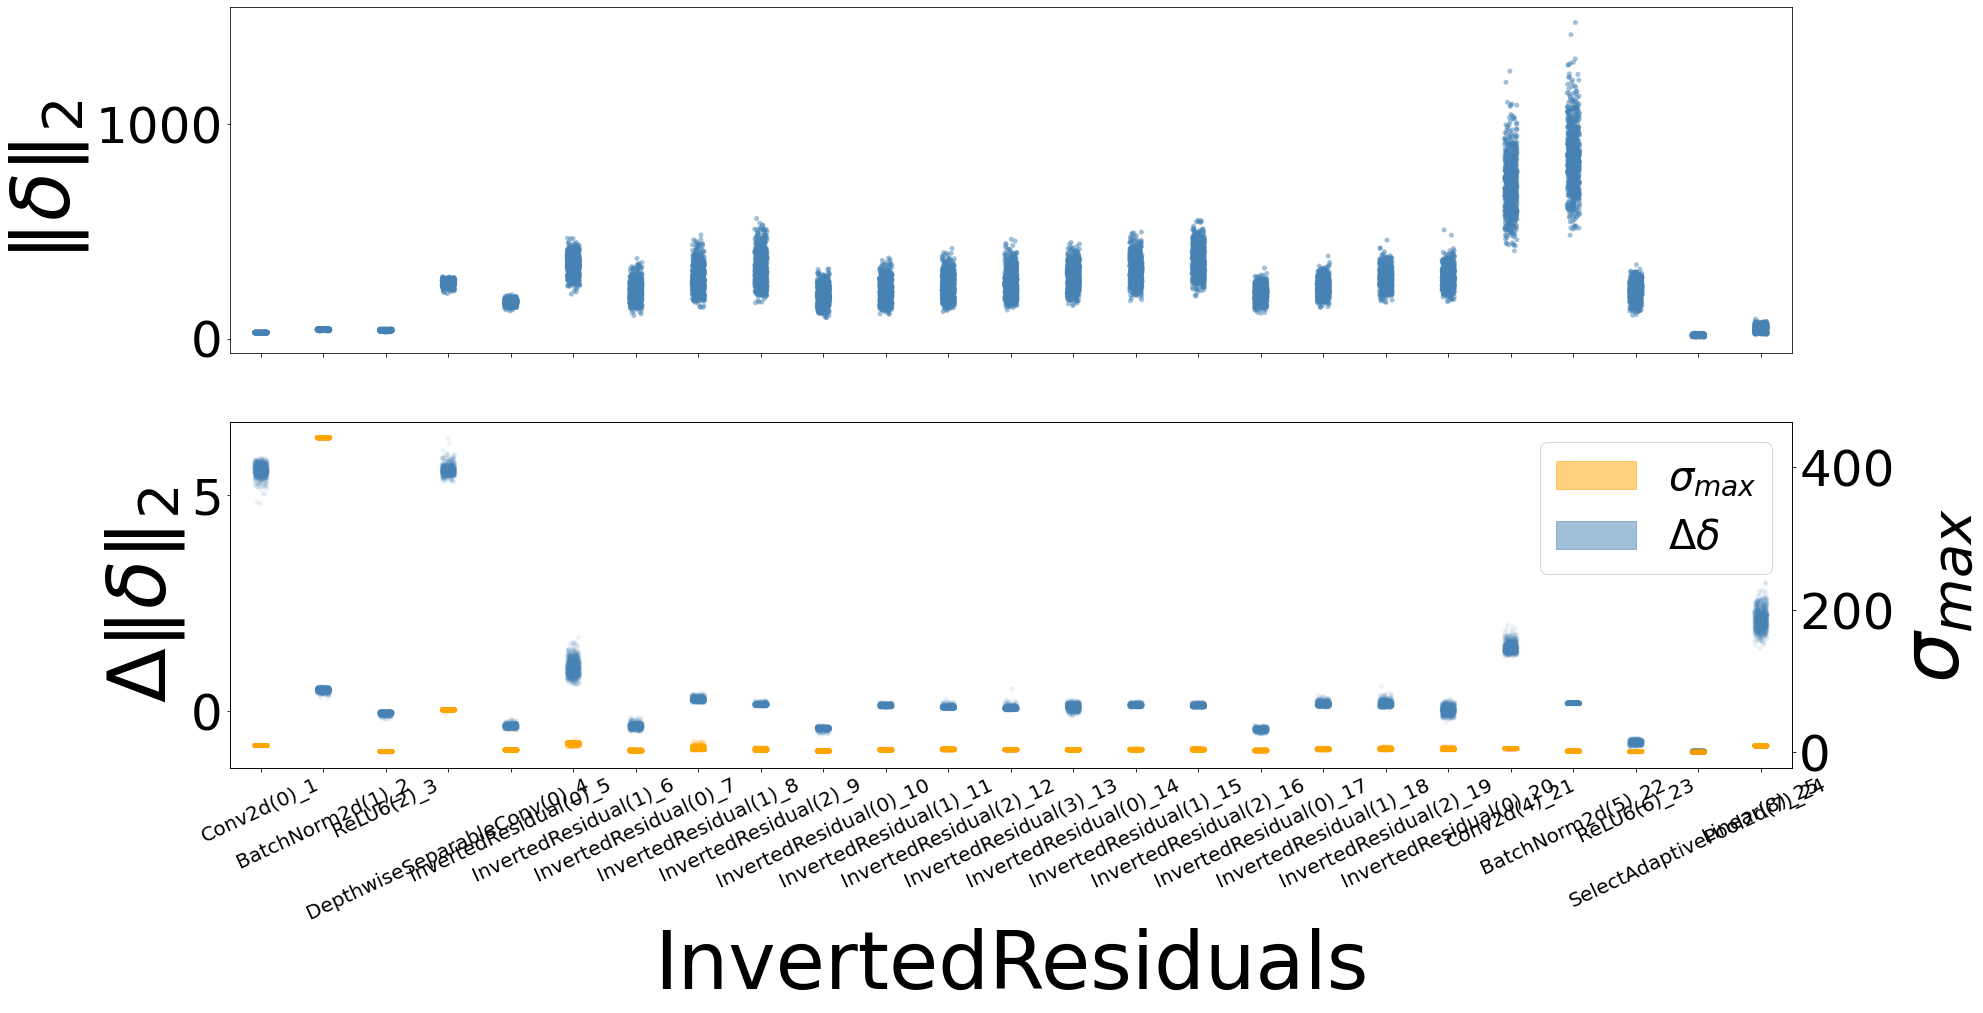

In [52]:
def preprocess(df):
    result = pd.DataFrame([])
    df = df.dropna(axis=1)
    for i, col in enumerate(df.columns):
        print(col)
        if i == 0:
            continue
        else: 
            result.loc[:,col] = (df.iloc[:,i] - df.iloc[:,i-1])/df.iloc[:,i-1]
    
    return result


def strip_plot(net_name, att_name,\
               col_interal=None, \
               dataset='imagenet',\
               add_market = True,
               rename_x_axis = False
               ):

    logger = Logger()
    if dataset == 'cifar10':
        iters = 20
    elif dataset == 'imagenet':
        iters = 100

    msv_file = f'msv_iters({iters})_for_{net_name}_on_{dataset}'
    att_file = f'{att_name}_for_{net_name}_on_{dataset}'

    logger._load_from_log(f'results/{msv_file}.csv', index_col=0)
    logger._load_from_log(f'results/{att_file}.csv', index_col=0)

    msv_df = logger.logging_files[msv_file]
    att_df = logger.logging_files[att_file]

    print(msv_df)
    print(msv_df.describe())
    print(att_df)
    print(att_df.describe())


    # select the columns 
    indications = ['label', 'prediction', 'pred_adv']
    cols = [col_name for col_name in msv_df.columns if col_name not in indications]    
        
    # conditions for successful attack and failed attack 
    succ_att = (att_df.loc[:,'label'] == att_df.loc[:,'prediction'])\
             &(att_df.loc[:,'prediction'] != att_df.loc[:,'pred_adv'])
    fail_att = (att_df.loc[:,'label'] == att_df.loc[:,'prediction'])\
             &(att_df.loc[:,'prediction'] == att_df.loc[:,'pred_adv'])

    # preprocess 
    _att_df= preprocess(att_df.loc[succ_att,cols])
    print(_att_df)
    print(_att_df.describe())
    print(net_name)
    cols = _att_df.columns
    att_df = att_df.loc[succ_att, cols]
    msv_df = msv_df.loc[succ_att, cols]


    fig, axs = plt.subplots(2,1,figsize=(28, 14), sharex=True)
    axs2 = axs[1].twinx()

    color_map = {
                'msv_succ':'orange',
                'msv_fail':'forestgreen',
                'att_succ':'steelblue',
                'att_fail':'orangered'
                }

    if col_interal == None:
        pass
    else:
        cols = cols[col_interal[0]:col_interal[1]]

    sns.stripplot(data=att_df.loc[:,cols], jitter=1, color='steelblue',\
                  ax=axs[0], alpha=0.5, marker='o', s=5)
    sns.stripplot(data=_att_df.loc[:,cols], jitter=1, color='steelblue', \
                  ax=axs[1], alpha=0.1, marker='o', s=5)
    sns.stripplot(data=msv_df.loc[:,cols], jitter=1, color='orange', \
                  ax=axs2, alpha=0.1, marker='o', s=5)


    # set x-axis: titles, fonts 
    axs[1].set_xlabel(cols[6].split('(')[0]+'s', fontsize=80)

    col_names_list = [i+1 for i in range(len(cols))]
    if rename_x_axis:
        axs[1].set_xticklabels(col_names_list, fontdict={'fontsize':50})
    else:
        axs[1].set_xticklabels(cols,
                    rotation=25,
                    fontdict={'fontsize':20})

    # set y-axis
    axs[0].set_ylabel(r'$\Vert \delta \Vert_2$', fontsize=80)
    axs[0].tick_params(axis='y', labelsize=50)

    axs[1].set_ylabel(r'$\Delta\Vert \delta\Vert_2$', fontsize=80)
    axs[1].tick_params(axis='y', labelsize=50)

    axs2.set_ylabel(r'$\sigma_{max}$', fontsize=80)
    axs2.tick_params(axis='y', labelsize=50)

    # set up marker for the legend
    if add_market:
        marker_msv_succ = mpatches.Patch(color='orange', label=r'$\sigma_{max}$', alpha=0.5)
        marker_att_succ = mpatches.Patch(color='steelblue', label=r'$\Delta\delta$', alpha=0.5)
        axs[1].legend(handles=[marker_msv_succ, marker_att_succ],  fontsize=40, \
                      loc='upper right'
                      )

att_names = ['aa_L2_eps(1.00)', 'fgsm_Linf_eps(0.01)', 'pgd_L2_eps(1.00)_alpha(0.01)_steps(50)', 'pgd_L2_eps(1.00)_alpha(0.01)_steps(7)']
strip_plot(net_on_imagenet[12], att_names[0], \
        # col_interal=(4,20), 
        # rename_x_axis = True,
        # add_market=False
           )

      InputResize(0)_0  Conv2d(0)_1  BatchNorm2d(1)_2  ReLU(2)_3  \
0             4.452096     6.785795        214.132233        1.0   
1             4.452149     6.786531        214.131989        1.0   
2             4.452103     6.781385        214.132172        1.0   
3             4.452099     6.782125        214.132492        1.0   
4             4.452096     6.785795        214.132233        1.0   
...                ...          ...               ...        ...   
1019          4.452099     6.782126        214.132492        1.0   
1020          4.452096     6.785795        214.132233        1.0   
1021          4.452149     6.786531        214.131989        1.0   
1022          4.452103     6.781384        214.132172        1.0   
1023          4.452099     6.782126        214.132492        1.0   

      MaxPool2d(3)_4  BasicBlock(0)_5  BasicBlock(1)_6  BasicBlock(2)_7  \
0           1.999652         6.136271        14.253550         5.270580   
1           1.999761         6.30

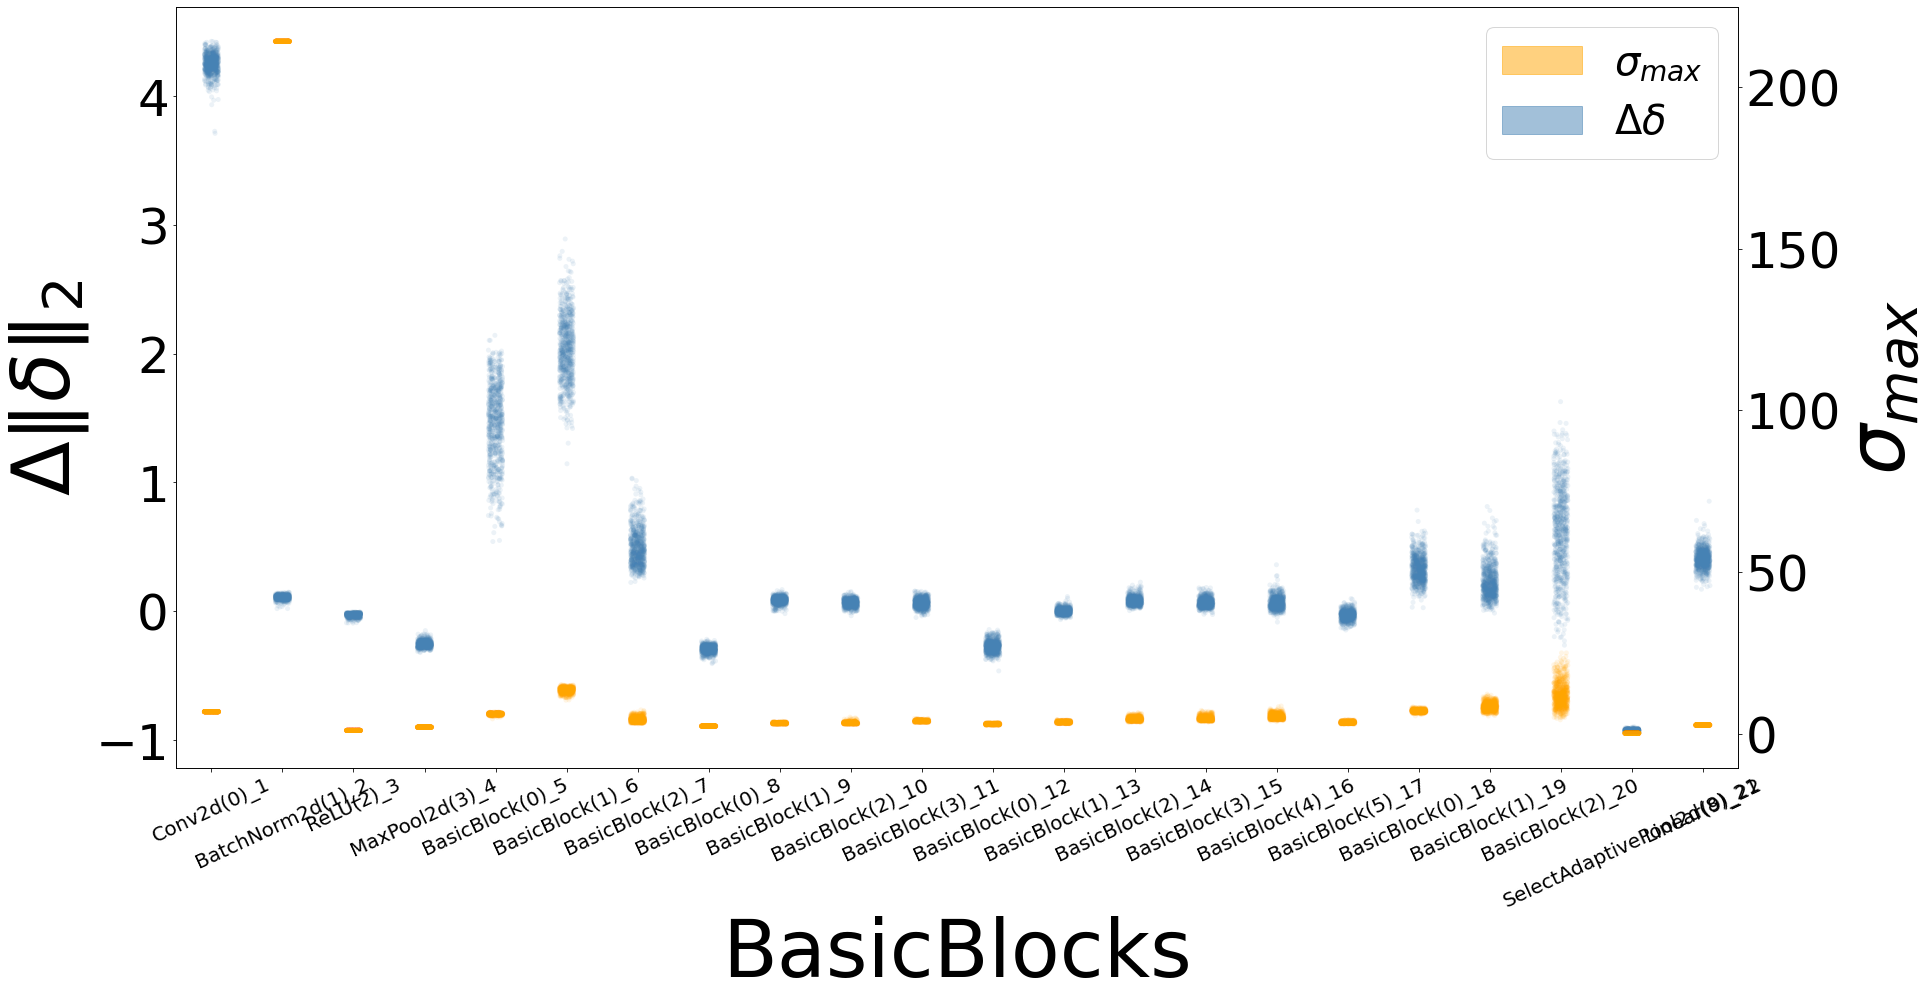

In [56]:
att_names = ['aa_L2_eps(1.00)', 'fgsm_Linf_eps(0.01)', 'pgd_L2_eps(1.00)_alpha(0.01)_steps(50)', 'pgd_L2_eps(1.00)_alpha(0.01)_steps(7)']
strip_plot(net_on_imagenet[1], att_names[0], \
        # col_interal=(4,20), 
        # rename_x_axis = True,
        # add_market=False
           )

In [203]:
net_name = resnet_imagenet_names[0]
att_name = 'aa_L2_eps(1.00)'
dataset = 'imagenet'
msv_file = f'msv_iters({100})_for_{net_name}_on_{dataset}'
att_file = f'{att_name}_for_{net_name}_on_{dataset}'
logger._load_from_log(f'results/{msv_file}.csv', index_col=0)
logger._load_from_log(f'results/{att_file}.csv', index_col=0)

indications = ['label', 'prediction', 'pred_adv']
msv_df = logger.logging_files[msv_file]
att_df = logger.logging_files[att_file]
cols = [col_name for col_name in att_df.columns if col_name not in indications]    
succ_att = (att_df.loc[:,'label'] == att_df.loc[:,'prediction'])\
            &(att_df.loc[:,'prediction'] != att_df.loc[:,'pred_adv'])


In [187]:
preprocess(att_df.loc[succ_att, cols])

InputResize(0)_0
Conv2d(0)_1
BatchNorm2d(1)_2
ReLU(2)_3
MaxPool2d(3)_4
BasicBlock(0)_5
BasicBlock(1)_6
BasicBlock(0)_7
BasicBlock(1)_8
BasicBlock(0)_9
BasicBlock(1)_10
BasicBlock(0)_11
BasicBlock(1)_12
SelectAdaptivePool2d(8)_13
Linear(9)_14


,Conv2d(0)_1,BatchNorm2d(1)_2,ReLU(2)_3,MaxPool2d(3)_4,BasicBlock(0)_5,BasicBlock(1)_6,BasicBlock(0)_7,BasicBlock(1)_8,BasicBlock(0)_9,BasicBlock(1)_10,BasicBlock(0)_11,BasicBlock(1)_12,SelectAdaptivePool2d(8)_13,Linear(9)_14
0,5.256646,-0.769692,-0.023170,-0.247192,2.268846,1.901532,-0.427438,0.313708,-0.391051,0.139040,-0.094827,11.467789,-0.912903,2.601564
1,5.182837,-0.772009,-0.040772,-0.237190,1.977106,1.722366,-0.460882,0.259445,-0.441501,0.151903,-0.145476,11.455367,-0.904387,1.979744
3,5.289001,-0.768928,-0.025301,-0.247803,2.343995,1.955248,-0.444896,0.296830,-0.324700,0.191680,-0.244840,8.972849,-0.910190,3.374991
4,5.257690,-0.773363,-0.031308,-0.252484,2.331160,2.128029,-0.425164,0.268821,-0.398381,0.187416,-0.156539,12.760563,-0.896749,2.897349
7,5.296876,-0.772943,-0.027454,-0.218297,2.311767,2.055225,-0.482249,0.295369,-0.387461,0.107232,-0.215965,11.577046,-0.910552,2.943962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,5.265016,-0.769183,-0.018055,-0.247637,2.285357,1.663426,-0.453301,0.311491,-0.375672,0.265032,-0.094361,12.065301,-0.894207,2.622555
1019,5.352953,-0.773266,-0.022541,-0.241226,2.459280,1.841301,-0.449470,0.207480,-0.474135,0.153808,-0.158084,13.353418,-0.892805,2.732643
1020,5.257403,-0.766799,-0.033719,-0.237514,1.844728,1.401512,-0.464274,0.287685,-0.331377,0.252339,0.104255,13.648867,-0.918436,2.865491
1021,5.324253,-0.767999,-0.022328,-0.280601,2.416810,1.998538,-0.444073,0.295349,-0.448897,0.203169,-0.156267,14.055945,-0.910110,3.093565


InputResize(0)_0
Conv2d(0)_1
BatchNorm2d(1)_2
ReLU(2)_3
MaxPool2d(3)_4
BasicBlock(0)_5
BasicBlock(1)_6
BasicBlock(2)_7
BasicBlock(0)_8
BasicBlock(1)_9
BasicBlock(2)_10
BasicBlock(3)_11
BasicBlock(0)_12
BasicBlock(1)_13
BasicBlock(2)_14
BasicBlock(3)_15
BasicBlock(4)_16
BasicBlock(5)_17
BasicBlock(0)_18
BasicBlock(1)_19
BasicBlock(2)_20
SelectAdaptivePool2d(8)_21
Linear(9)_22
InputResize(0)_0
Conv2d(0)_1
BatchNorm2d(1)_2
ReLU(2)_3
MaxPool2d(3)_4
Bottleneck(0)_5
Bottleneck(1)_6
Bottleneck(2)_7
Bottleneck(0)_8
Bottleneck(1)_9
Bottleneck(2)_10
Bottleneck(3)_11
Bottleneck(0)_12
Bottleneck(1)_13
Bottleneck(2)_14
Bottleneck(3)_15
Bottleneck(4)_16
Bottleneck(5)_17
Bottleneck(0)_18
Bottleneck(1)_19
Bottleneck(2)_20
SelectAdaptivePool2d(8)_21
Linear(9)_22


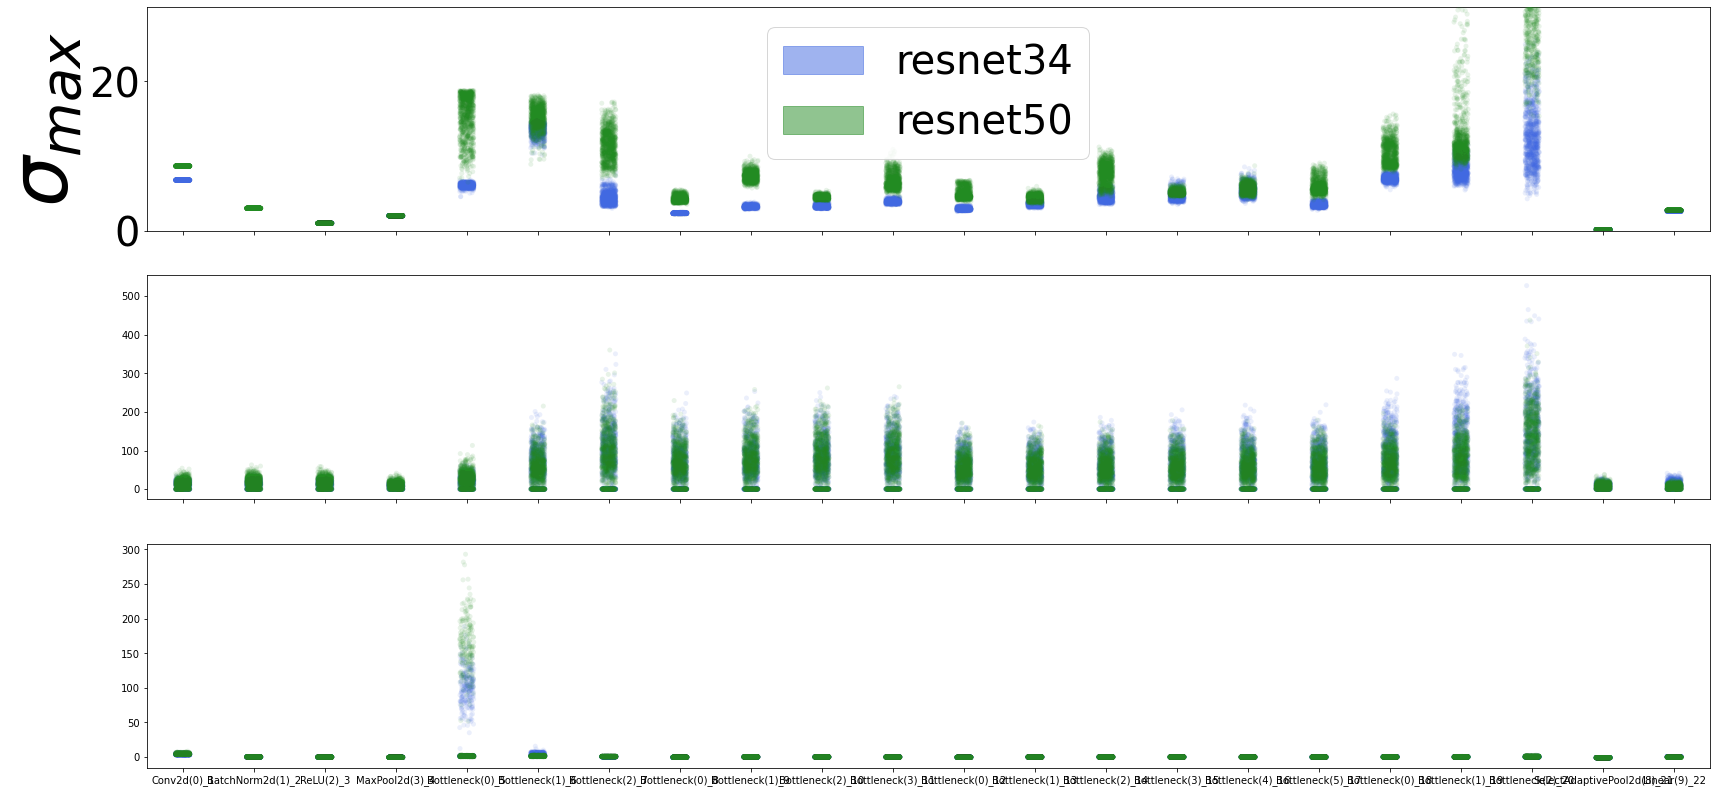

In [48]:
def strip_plot_model_compare(net_names, att_name,\
                             col_interal=None, \
                             dataset='imagenet',\
                            ):

    logger = Logger()
    if dataset == 'cifar10':
        iters = 20
    elif dataset == 'imagenet':
        iters = 100

    # load the data needed
    msv_files = []
    att_files = []
    for net_name in net_names:
        msv_files.append(f'msv_iters({iters})_for_{net_name}_on_{dataset}')
        att_files.append(f'{att_name}_for_{net_name}_on_{dataset}')
        logger._load_from_log(f'results/{msv_files[-1]}.csv', index_col=0)
        logger._load_from_log(f'results/{att_files[-1]}.csv', index_col=0)

    fig, axs = plt.subplots(3, 1, figsize=(28, 14), sharex=True)
    color_list = ['royalblue', 'forestgreen', 'mediumspringgreen', 'orange', 'burlywood', 'red', 'coral']



    for i, msv_file in enumerate(msv_files):
        msv_df = logger.logging_files[msv_file]
        att_df = logger.logging_files[att_files[i]]
        # select the columns 
        indications = ['label', 'prediction', 'pred_adv']
        cols = [col_name for col_name in msv_df.columns if col_name not in indications]    

        _att_df= preprocess(att_df.loc[:,cols])
        cols = _att_df.columns


        if col_interal == None:
            pass
        else:
            cols = cols[col_interal[0]:col_interal[1]]

        sns.stripplot(data=msv_df.loc[:,cols], jitter=1, color=color_list[i], \
                      ax=axs[0], alpha=0.1, marker='o', s=5)
        sns.stripplot(data=att_df.loc[:,cols], jitter=1, color=color_list[i], \
                      ax=axs[1], alpha=0.1, marker='o', s=5)
        sns.stripplot(data=_att_df.loc[:,cols], jitter=1, color=color_list[i], \
                      ax=axs[2], alpha=0.1, marker='o', s=5)

    # set x-axis: titles, fonts 
    # axs[0].set_xlabel('Blocks', fontsize=80)

    col_names_list = [i+1 for i in range(len(cols))]
    for i in range(3):
        axs[i].set_xticklabels(cols, fontdict={'fontsize':10})

    # set y-axis
    axs[0].set_ylabel(r'$\sigma_{max}$', fontsize=80)
    axs[0].tick_params(axis='y', labelsize=40)
    axs[0].set_ylim(0,30)

    # set up marker for the legend
    markers = []
    for i in range(len(msv_files)):
        markers.append(mpatches.Patch(color=color_list[i], label=net_names[i], alpha=0.5))
    axs[0].legend(handles=markers,  fontsize=40, \
                #   loc='upper left'
                 )

nets = ['resnet34', 'resnet50', 'wide_resnet50_2', 'resnext50_32x4d', 'mobilenetv2_100', 'mobilenetv3_large_100']
att_names = ['aa_L2_eps(1.00)', 'cw_L2_c(1.0)_kappa(0.0)_lr(0.01)_steps(500)']
strip_plot_model_compare(nets[0:2], att_names[1],
                        #  col_interal=(4,20), 
                        )

In [174]:
tab.loc[:, ].to_csv('./log/results/output_all_nets.csv')

In [73]:
from scipy import stats
net_names = []
dataset = 'imagenet'

class ResultAnalysis(Logger):
    def __init__(self):
        super(ResultAnalysis, self).__init__()
        self.data_msv_all = {} 
        self.data_msv_body = {}     
        self.msv_files = []
        
        self.data_att_body = []
        self.att_files = []

    @staticmethod
    def _preprocess(df):
        result = pd.DataFrame([])
        df = df.dropna(axis=1)
        for i, col in enumerate(df.columns):
            print(col)
            if i == 0:
                continue
            else: 
                result.loc[:,col] = (df.iloc[:,i] - df.iloc[:,i-1])/df.iloc[:,i-1]
        
        return result

    def load_preprocess(self, net_name, att_name, dataset):
        # load the results 
        if dataset == 'cifar10':
            iters = 20
        elif dataset == 'imagenet':
            iters = 100

        # append the file name 
        msv_file = f'msv_iters({iters})_for_{net_name}_on_{dataset}'
        att_file = f'{att_name}_for_{net_name}_on_{dataset}'

        self.msv_files.append(msv_file)
        self.att_files.append(att_file)

        # load the file 
        self._load_from_log(f'results/{msv_file}.csv', index_col=0)
        self._load_from_log(f'results/{att_file}.csv', index_col=0)
        msv_df = self.logging_files[msv_file]
        att_df = self.logging_files[att_file]

        # take out the columns that is not used 
        cols = [col_name for col_name in msv_df.columns if \
                col_name not in ['label', 'prediction', 'pred_adv']
                ]    

        # conditions for successful attack and failed attack 
        succ_att = (att_df.loc[:,'label'] == att_df.loc[:,'prediction'])\
                    &(att_df.loc[:,'prediction'] != att_df.loc[:,'pred_adv'])

        # preprocess 
        _att_df= self._preprocess(att_df.loc[succ_att,cols])
        cols = _att_df.columns

        # calculate the msv for all layers 
        self.data_msv_all[net_name] =  msv_df.loc[:, cols].mean(axis=1)

        # calculate the msv for the body layers 
        cols_body = [col_name for col_name in cols if col_name.split('(')[0] in \
                    ['BasicBlock', 'Bottleneck', 'Block', 'MixerBlock', 'Bottleneck', 'InvertedResidual',\
                     'EncoderBlock', 'EncoderBlock_Conv1D']]
        self.data_msv_body[net_name] = msv_df.loc[:, cols_body].mean(axis=1)

        # calculate the percentage change of perturbation for attacks 
        self.data_att_body[net_name] = _att_df.loc[succ_att, cols].mean(axis=1)

    def compare_att_msv(self, net_names, att_names=['aa_L2_eps(1.00)'], dataset='imagenet'):
        result_tab = {}
        result_tab['networks'] = []
        result_tab['delta_mean'] = []
        result_tab['delta_std'] = []

        result_tab['msv_mean'] = []
        result_tab['msv_std'] = []

        for att_name in att_names:
            for net_name in net_names:
                self.load_preprocess(net_name, att_name, dataset)
                result_tab['networks'].append(net_name)
                result_tab['delta_mean'].append(self.data_att_body[net_name].mean())
                result_tab['msv_mean'].append(self.data_msv_body[net_name].mean())
                result_tab['delta_std'].append(self.data_att_body[net_name].std())
                result_tab['msv_std'].append(self.data_msv_body[net_name].std())

        self._save_to_log(result_tab, 'networks', 'results/output_compare.csv')

result_analysis = ResultAnalysis()
result_analysis.compare_att_msv()

    # def _create_matrix_tab(self, net_names, data_msv):
    #     matrix_tab = pd.DataFrame([])
    #     matrix_tab.loc[:,'networks'] = net_names
    #     for net_name in net_names:
    #         matrix_tab.loc[:,net_name] = []
    #     matrix_tab.reset_index('networks')

    #     for net_name_1 in net_names:
    #         for net_name_2 in net_names:
    #             data_msv[net_name] 
    #             t, p = stats.ttest_ind(data_msv[net_name_1], data_msv[net_name_2], equal_var = False)
    #             matrix_tab.loc[net_name_1, net_name_2] = [p]

    # def create_matrix_tab(self, net_names, include_cols='all'):
    #     if include_cols == 'all':
    #         self._create_matrix_tab(net_names, self.data_msv_all) 
    #     elif include_cols == 'body':
    #         self._create_matrix_tab(net_names, self.data_msv_body) 


ValueError: Length of values (0) does not match length of index (20)

In [69]:
from scipy import stats

rvs1 = stats.norm.rvs(loc=7.6,scale=0.8,size=500)
rvs2 = stats.norm.rvs(loc=7.93,scale=0.36,size=500)
# stats.ttest_ind(rvs1,rvs2)
s, p = stats.ttest_ind(rvs1,rvs2, equal_var = False)


In [70]:
p

1.940167424246302e-17

In [67]:
rvs1.mean()

5.407458472763024

(array([  3.,  11.,  44.,  85., 123., 131.,  71.,  23.,   8.,   1.]),
 array([1.71190609, 2.37695544, 3.04200478, 3.70705412, 4.37210346,
        5.0371528 , 5.70220214, 6.36725148, 7.03230082, 7.69735016,
        8.36239951]),
 <BarContainer object of 10 artists>)

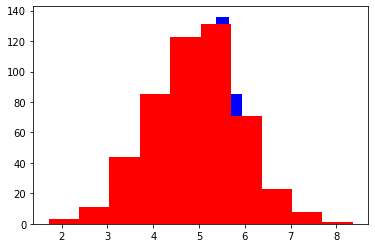

In [65]:
import matplotlib.pyplot as plt 
plt.hist(rvs1, color='b')
plt.hist(rvs2, color='r')

In [101]:
import torch 
import argparse 
import timm 
    
from util import *
from analyze_model import *
from analyze_model.util import *
from build_model.util import *

net_name = 'resnet34'

net = timm.create_model(net_name, pretrained=True)
module_tree = nnTree({'named_module': (net_name, net)})

if net_name in ['resnet18', 'resnet34', 'resnet50', 'resnet34d', 'resnet50d', 'resnet101d', 'resnet152d',\
                'wide_resnet50_2', 'wide_resnet101_2',\
                'resnext50_32x4d', 'resnext50d_32x4d', 'resnext101_32x8d']:
    module_tree.decompose([[1], [0]*4 + [1]*4 +[0]*2])
elif net_name in ['mobilenetv2_100', 'mobilenetv3_large_100']:
    module_tree.decompose([[1], [0]*4 + [2] +[0]*5])
elif net_name in ['vit_small_patch16_224', 'vit_base_patch16_224', 'vit_large_patch16_224']:
    module_tree.decompose([[1], [0]*3 + [1] +[0]*3])
elif net_name in ['mixer_b16_224', 'mixer_b16_224_miil', 'mixer_l16_224']:
    module_tree.decompose([[1], [0]*2 + [1] +[0]*2])


In [106]:

output_list = {}
x = torch.rand([1, 3, 224, 224])
for i, module in enumerate(module_tree.decomposed_modules):
    x = module(x)
    output_list[f'{module.__repr__()}_{i}'] = x.shape

In [107]:
output_list

{'Conv2d(0)_0': torch.Size([1, 64, 112, 112]),
 'BatchNorm2d(1)_1': torch.Size([1, 64, 112, 112]),
 'ReLU(2)_2': torch.Size([1, 64, 112, 112]),
 'MaxPool2d(3)_3': torch.Size([1, 64, 56, 56]),
 'BasicBlock(0)_4': torch.Size([1, 64, 56, 56]),
 'BasicBlock(1)_5': torch.Size([1, 64, 56, 56]),
 'BasicBlock(2)_6': torch.Size([1, 64, 56, 56]),
 'BasicBlock(0)_7': torch.Size([1, 128, 28, 28]),
 'BasicBlock(1)_8': torch.Size([1, 128, 28, 28]),
 'BasicBlock(2)_9': torch.Size([1, 128, 28, 28]),
 'BasicBlock(3)_10': torch.Size([1, 128, 28, 28]),
 'BasicBlock(0)_11': torch.Size([1, 256, 14, 14]),
 'BasicBlock(1)_12': torch.Size([1, 256, 14, 14]),
 'BasicBlock(2)_13': torch.Size([1, 256, 14, 14]),
 'BasicBlock(3)_14': torch.Size([1, 256, 14, 14]),
 'BasicBlock(4)_15': torch.Size([1, 256, 14, 14]),
 'BasicBlock(5)_16': torch.Size([1, 256, 14, 14]),
 'BasicBlock(0)_17': torch.Size([1, 512, 7, 7]),
 'BasicBlock(1)_18': torch.Size([1, 512, 7, 7]),
 'BasicBlock(2)_19': torch.Size([1, 512, 7, 7]),
 'Selec

In [105]:
module_tree.decomposed_modules

[Conv2d(0),
 BatchNorm2d(1),
 ReLU(2),
 MaxPool2d(3),
 BasicBlock(0),
 BasicBlock(1),
 BasicBlock(2),
 BasicBlock(0),
 BasicBlock(1),
 BasicBlock(2),
 BasicBlock(3),
 BasicBlock(0),
 BasicBlock(1),
 BasicBlock(2),
 BasicBlock(3),
 BasicBlock(4),
 BasicBlock(5),
 BasicBlock(0),
 BasicBlock(1),
 BasicBlock(2),
 SelectAdaptivePool2d(8),
 Linear(9)]

In [21]:
import pandas as pd 

msv_df_resnet34 = pd.read_csv('./log/results/msv_iters(100)_for_resnet34_on_imagenet.csv')
msv_df_resnet50 = pd.read_csv('./log/results/msv_iters(100)_for_resnet50_on_imagenet.csv')


In [49]:
cols = msv_df_resnet34.columns[2:-3]
cols

Index(['Conv2d(0)_1', 'BatchNorm2d(1)_2', 'ReLU(2)_3', 'MaxPool2d(3)_4',
       'BasicBlock(0)_5', 'BasicBlock(1)_6', 'BasicBlock(2)_7',
       'BasicBlock(0)_8', 'BasicBlock(1)_9', 'BasicBlock(2)_10',
       'BasicBlock(3)_11', 'BasicBlock(0)_12', 'BasicBlock(1)_13',
       'BasicBlock(2)_14', 'BasicBlock(3)_15', 'BasicBlock(4)_16',
       'BasicBlock(5)_17', 'BasicBlock(0)_18', 'BasicBlock(1)_19',
       'BasicBlock(2)_20', 'SelectAdaptivePool2d(8)_21', 'Linear(9)_22'],
      dtype='object')

In [55]:
msv_df_resnet34.loc[:, cols]

,Conv2d(0)_1,BatchNorm2d(1)_2,ReLU(2)_3,MaxPool2d(3)_4,BasicBlock(0)_5,BasicBlock(1)_6,BasicBlock(2)_7,BasicBlock(0)_8,BasicBlock(1)_9,BasicBlock(2)_10,...,BasicBlock(1)_13,BasicBlock(2)_14,BasicBlock(3)_15,BasicBlock(4)_16,BasicBlock(5)_17,BasicBlock(0)_18,BasicBlock(1)_19,BasicBlock(2)_20,SelectAdaptivePool2d(8)_21,Linear(9)_22
0,6.785795,214.132233,1.0,1.999652,6.136271,14.253550,5.270580,2.346396,3.243455,3.367406,...,3.551010,5.324162,4.608187,5.750571,3.439528,6.552498,9.390498,11.599319,0.142857,2.702804
1,6.786531,214.131989,1.0,1.999761,6.302615,12.864045,5.891355,2.321048,2.928822,3.436427,...,3.500008,4.445340,4.461116,5.692230,3.164409,6.887613,8.513103,9.724527,0.142857,2.576406
2,6.781385,214.132172,1.0,1.999734,6.003371,13.392117,4.364579,2.309752,3.233705,3.127774,...,3.336289,3.803705,5.854350,5.805158,3.110908,5.889482,8.459183,13.061090,0.142857,2.703194
3,6.782125,214.132492,1.0,1.999678,6.214613,14.267667,4.536399,2.285057,3.400077,3.163893,...,3.750021,4.030034,5.741294,6.195154,3.584471,7.079691,10.837443,9.092951,0.142857,2.702929
4,6.785795,214.132233,1.0,1.999696,6.368986,14.193679,4.269780,2.366454,3.468770,4.481249,...,4.042451,3.819064,4.456444,4.337203,3.349221,6.751857,6.817506,19.261721,0.142857,2.702804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,6.782126,214.132492,1.0,1.999826,6.565197,12.299037,4.596907,2.305645,3.353571,3.762863,...,3.574312,4.274000,3.844483,4.685415,3.160945,7.267050,8.826710,12.005007,0.142857,2.702929
1020,6.785795,214.132233,1.0,1.999694,6.000786,13.540614,3.885769,2.300944,2.942746,3.237511,...,3.074462,4.986333,5.166789,5.714390,3.899461,7.183086,6.572719,24.974817,0.142857,2.702804
1021,6.786531,214.131989,1.0,1.999686,6.137488,13.780210,5.026423,2.259814,3.490002,3.357572,...,4.275607,5.612496,4.493019,4.328397,3.401840,7.422316,7.311393,17.143572,0.142857,2.576406
1022,6.781384,214.132172,1.0,1.999706,6.240211,13.850539,4.268138,2.370994,3.289501,3.319552,...,3.441354,4.091441,5.669934,5.979959,3.429124,6.922092,8.087647,12.075290,0.142857,2.703194


In [54]:
msv_df_resnet50.loc[:,msv_df_resnet50.columns[2:-3]].mean()

Conv2d(0)_1                    8.661918
BatchNorm2d(1)_2               3.007190
ReLU(2)_3                      1.000000
MaxPool2d(3)_4                 1.999701
Bottleneck(0)_5               15.330263
Bottleneck(1)_6               15.170474
Bottleneck(2)_7               11.461895
Bottleneck(0)_8                4.280555
Bottleneck(1)_9                7.357673
Bottleneck(2)_10               4.503152
Bottleneck(3)_11               6.644386
Bottleneck(0)_12               4.930542
Bottleneck(1)_13               4.416420
Bottleneck(2)_14               7.648590
Bottleneck(3)_15               5.134365
Bottleneck(4)_16               5.647260
Bottleneck(5)_17               5.928063
Bottleneck(0)_18              10.302440
Bottleneck(1)_19              13.517342
Bottleneck(2)_20              34.638435
SelectAdaptivePool2d(8)_21     0.142857
Linear(9)_22                   2.740841
dtype: float64

In [62]:
training_res = pd.read_csv('./log/results/training_results.csv')

In [65]:
training_res.loc[training_res.loc[:,'epoch'] == 200].to_csv('./log/results/training_results_200.csv')